In [3]:
import os
import torch
import matplotlib.pyplot as plt
plt.set_loglevel(level = 'warning')

# Load Model Predictions

In [2]:
base_dir = '/shared/share_mala/implicitbayes/dataset_files/synthetic_data/beta/N=500,D=25000,D_eval=10000,cnts=5/models/0423_synthetic_bb/'

In [4]:
model_paths = {
    'seq_bb': base_dir+'/sequential:epochs=2000,bs=500,lr=0.001,wd=0.01,MLP_layers=3,MLP_width=100,weight_factor=1,max_obs=500,repeat_suffstat=10,Zdim=1,sched=constant,BB=True,alphabeta=True,seed=2340923'
}

In [21]:
prediction_dicts = {}
for name, run_dir in model_paths.items():
    preds = torch.load(run_dir + '/best_loss_predictions.pt')
    prediction_dicts[name] = preds

prediction_dicts.keys()

dict_keys(['seq_bb'])

In [37]:
dataset = 'val'

In [38]:
from closed_form_models import BetaBernoulli

In [39]:
new_prediction_dicts = {}

In [40]:
onekey = list(prediction_dicts.keys())[0]

In [41]:
# BETA BERNOULLI MODELS =====================================================================================

all_BB_models = {}


# Standard beta comparison =============================
prior_means_eval = preds[dataset]['theta_hats']
true_means_train = preds['train']['click_rates']
prior_dict = {
                "alpha": prior_means_eval[:,0]*0+1,
                "beta": prior_means_eval[:,0]*0+1,
                }
bb_model_eval_marginal = BetaBernoulli(prior_dict)
obs_seq_eval = preds[dataset]['click_obs']
post_alpha, post_beta = bb_model_eval_marginal.compute_posterior_seq(obs_seq_eval)
post_means, post_vars = bb_model_eval_marginal.compute_post_mean_var(post_alpha, post_beta)

new_prediction_dicts[f"Beta-Bernoulli (Standard)"] = { dataset : { "theta_hats": post_means,
                                                        "click_rates": preds[dataset]['click_rates'].squeeze()
                                                                        } }
all_BB_models['Standard'] = bb_model_eval_marginal


# Oracle beta comparison =============================
Zvec = prediction_dicts[onekey][dataset]['Z']
cnts=5
alpha = Zvec*cnts+1
beta = (1-Zvec)*cnts+1
prior_dict = {
                "alpha": alpha,
                "beta": beta,
                }
bb_model_eval_marginal = BetaBernoulli(prior_dict)
obs_seq_eval = preds[dataset]['click_obs']
post_alpha, post_beta = bb_model_eval_marginal.compute_posterior_seq(obs_seq_eval)
post_means, post_vars = bb_model_eval_marginal.compute_post_mean_var(post_alpha, post_beta)

new_prediction_dicts[f"Beta-Bernoulli (Oracle)"] = { dataset : { "theta_hats": post_means,
                                                        "click_rates": preds[dataset]['click_rates'].squeeze()
                                                                        } }
all_BB_models['Oracle'] = bb_model_eval_marginal

all_prediction_dicts = {**prediction_dicts, **new_prediction_dicts}

In [42]:
# Process the prediction dictionaries
model2predictions = {}
for name, pred_dict in all_prediction_dicts.items():
    print(name)
    model2predictions[name] = {
        'p_hats_eval': pred_dict[dataset]['theta_hats'],
        'true_p_eval': pred_dict[dataset]['click_rates'].squeeze(),
    }

seq_bb
Beta-Bernoulli (Standard)
Beta-Bernoulli (Oracle)


# Evaluate Model Predictions

In [28]:
import imp
import eval_metrics_and_plotting
from collections import defaultdict, OrderedDict
imp.reload(eval_metrics_and_plotting)

from eval_metrics_and_plotting import get_prediction_metric_values, make_plot_from_predictions

In [29]:
all_plot_keys = [k for k in model2predictions.keys()]
all_plot_keys

['seq_bb', 'Beta-Bernoulli (Standard)', 'Beta-Bernoulli (Oracle)']

# Posterior Evaluation

In [14]:
from eval_metrics_and_plotting import credible_interval_results, draw_posterior_samples_MIND

all_posteriors_dict = {}
all_num_prev_obs = [0]
num_repetitions = 10000

In [15]:
all_BB_models.keys()

dict_keys(['Standard', 'Oracle'])

In [43]:
# Draw posterior samples from Beta-Bernoulli models ---------------------
true_p_eval = model2predictions[all_plot_keys[0]]['true_p_eval']
all_prev_obs = prediction_dicts[all_plot_keys[0]][dataset]['click_obs']

for name, bbmodel in all_BB_models.items():
    if name != 'Oracle': continue
    all_posteriors_dict[name] = {}
    for num_prev_obs in all_num_prev_obs:
        prev_obs = all_prev_obs[:,:num_prev_obs]
        posterior_samples = bbmodel.posterior_samples(prev_obs, num_repetitions)
        all_posteriors_dict[name][num_prev_obs] = {
            'val_post_samples': posterior_samples[:1000],
            'val_true_p': true_p_eval[:1000]
        }

In [47]:
# Load posterior samples from other models
post_sample_models = ['seq_bb'] 
for name in post_sample_models:
    
    all_posteriors_dict[name] = {}
    run_dir = model_paths[name]
    post_samples = torch.load(run_dir + '/best_loss_posterior_samples.pt')
    
    for num_prev_obs in all_num_prev_obs:
        tuplekey = (num_prev_obs, 500, 10000)
        all_posteriors_dict[name][num_prev_obs] = {
            'val_post_samples': post_samples[dataset][tuplekey]['post_samples'],
            'val_true_p': true_p_eval[:1000]
        }

In [49]:
from eval_metrics_and_plotting import compare_posteriors, mean_abs_diff_from_mean, plot_scatter

In [52]:
num_prev = 0

In [61]:
sample_draws = all_posteriors_dict['seq_bb'][num_prev]['val_post_samples'][:100,:10000]
oracle_draws = all_posteriors_dict['Oracle'][num_prev]['val_post_samples'][:100,:10000]

In [64]:
from util import make_plots_good
make_plots_good()

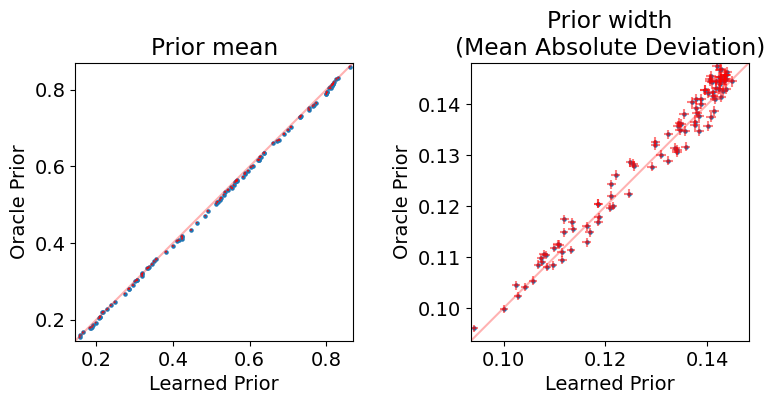

In [66]:
figsize=(8,4)
fig,ax = plt.subplots(1,2,figsize=figsize)
s = 5
metrics = {
    'Mean': lambda x: x.mean(1),
    'Mean |sample - mean|': lambda x: mean_abs_diff_from_mean(x).mean(1),
}
sd_metrics = {
    'Mean': lambda x: x.std(1) / x.shape[1] ** 0.5,
    'Mean |sample - mean|': lambda x: mean_abs_diff_from_mean(x).std(1) / x.shape[1] ** 0.5,
}
for i, (metric, fn) in enumerate(metrics.items()):
    x = fn(sample_draws)
    y = fn(oracle_draws)
    plot_scatter(x, y, ax=ax[i], title=metric, s=s)  
    if metric in sd_metrics.keys():
        xerr = sd_metrics[metric](sample_draws)
        yerr = sd_metrics[metric](oracle_draws)
        ax[i].errorbar(x, y, xerr=xerr, yerr=yerr, fmt="none", c='r', alpha=0.5)

ax[0].set_title('Prior mean')
ax[1].set_title('Prior width\n(Mean Absolute Deviation)')
xlabel = 'Learned Prior'
for a in ax:
    a.set_xlabel(xlabel)
    a.set_ylabel('Oracle Prior')
fig.tight_layout()